In [14]:
import os
from sam.dose_reponse_fit import dose_response_fit, ModelPredictions, survival_to_stress, FitSettings, Transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sam.data_formats import read_data, load_files
from sam.plotting import plot_fit_prediction

In [15]:
dfs = []

for path, data in load_files():
    
    meta = data.meta
    res : ModelPredictions = dose_response_fit(data.main_series, FitSettings(param_d_norm=True, survival_max= meta.max_survival))
    
    title = f"{meta.chemical} - {meta.organism}"
    
    dfs.append({"title" : path[:-4], "chemical":meta.chemical, "organism":meta.organism, "model": res})

df = pd.DataFrame(dfs)
df.head()    

,title,chemical,organism,model
0,/home/felix/Desktop/sam/data/ayesha_chlorantra...,Chlrorantraniliprole,Gammarus pulex,ModelPredictions(concentration_curve=array([1....
1,/home/felix/Desktop/sam/data/huang_Flupyradifu...,Flupyradifurone,Gammarus pulex,ModelPredictions(concentration_curve=array([1....
2,/home/felix/Desktop/sam/data/naeem_Esfenvalera...,Esfenvalerate,Daphnia magna,ModelPredictions(concentration_curve=array([1....
3,/home/felix/Desktop/sam/data/ayesha-cloth_Clot...,Clothianidin,Gammarus pulex,ModelPredictions(concentration_curve=array([1....
4,/home/felix/Desktop/sam/data/ayesha_chlorantra...,Chlrorantraniliprole,Gammarus pulex,ModelPredictions(concentration_curve=array([1....


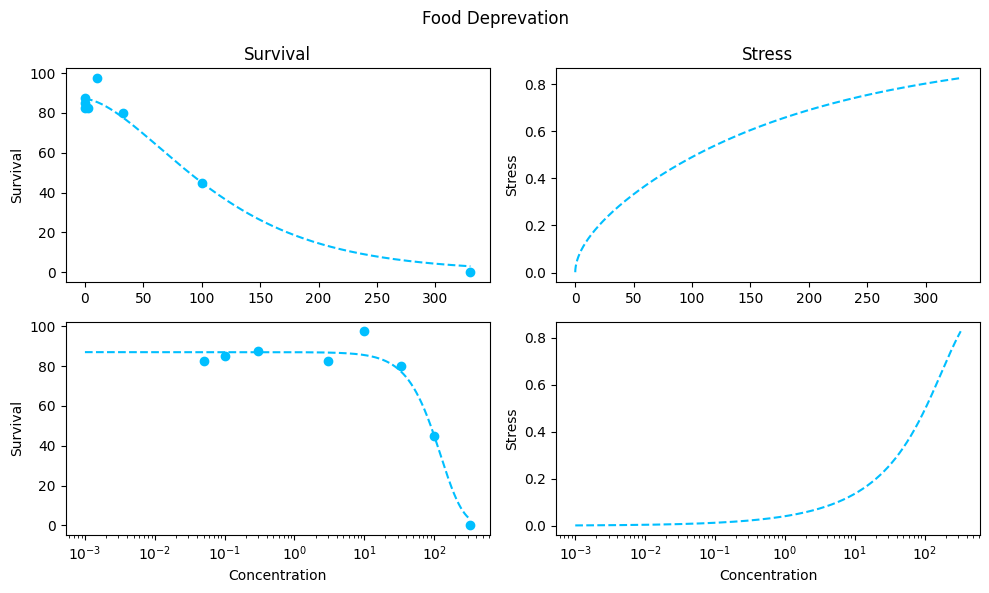

In [16]:
model = df.query("chemical == 'Food Deprevation'").iloc[0].model
fig = plot_fit_prediction(model, "Food Deprevation")

In [17]:
df.chemical.value_counts()

chemical
Clothianidin            6
Chlrorantraniliprole    2
Esfenvalerate           2
Copper                  2
Flupyradifurone         1
BPS                     1
Mix13                   1
Food Deprevation        1
Imidachloprid           1
Salt (NaCl)             1
Name: count, dtype: int64

In [18]:
df.organism.value_counts()

organism
Gammarus pulex    10
Daphnia magna      6
Unknown            1
Amphipod           1
Name: count, dtype: int64

In [19]:
df.value_counts(["chemical", "organism"])

chemical              organism      
Clothianidin          Gammarus pulex    6
Chlrorantraniliprole  Gammarus pulex    2
Esfenvalerate         Daphnia magna     2
BPS                   Daphnia magna     1
Copper                Amphipod          1
                      Daphnia magna     1
Flupyradifurone       Gammarus pulex    1
Food Deprevation      Daphnia magna     1
Imidachloprid         Gammarus pulex    1
Mix13                 Unknown           1
Salt (NaCl)           Daphnia magna     1
Name: count, dtype: int64

In [20]:
def compute_normalised_curve(model : ModelPredictions):
    
    if np.isnan(model.lc1):
        print("nan")
        model.lc1 = 0.0
    
    x = np.linspace(model.lc1, model.lc99, 1000)
    
    return model.model(x) * 100


df["normed_curves"] = df.model.apply(compute_normalised_curve)

df["stress"] = df.normed_curves.apply(lambda x: survival_to_stress(x / 100))

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


/tmp/ipykernel_29856/200940450.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {chemical: color for chemical, color in zip(chemicals, plt.cm.get_cmap('tab10').colors)}


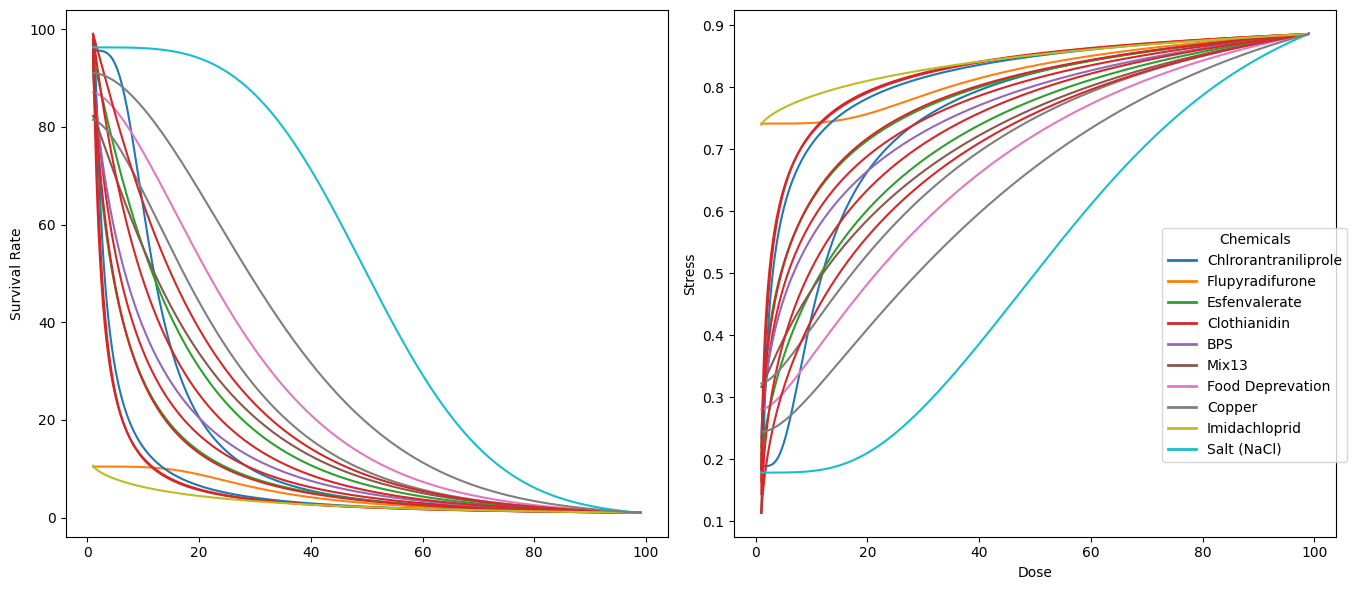

In [21]:
chemicals = df['chemical'].unique()
color_map = {chemical: color for chemical, color in zip(chemicals, plt.cm.get_cmap('tab10').colors)}

# Plot each chemical with the assigned color
fig = plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
for col, row in df.iterrows():
    plt.plot(np.linspace(1, 99, 1000), row['normed_curves'], color=color_map[row['chemical']])

plt.ylabel('Survival Rate')
plt.subplot(1,2,2)
for col, row in df.iterrows():
    plt.plot(np.linspace(1, 99, 1000), row.stress, color=color_map[row['chemical']])


handles = [plt.Line2D([0], [0], color=color_map[chem], lw=2) for chem in chemicals]
labels = [chem for chem in chemicals]
plt.legend(handles, labels, title="Chemicals", bbox_to_anchor = (0.7,0.6))

plt.xlabel('Dose')
plt.ylabel('Stress')
plt.tight_layout()
plt.show()

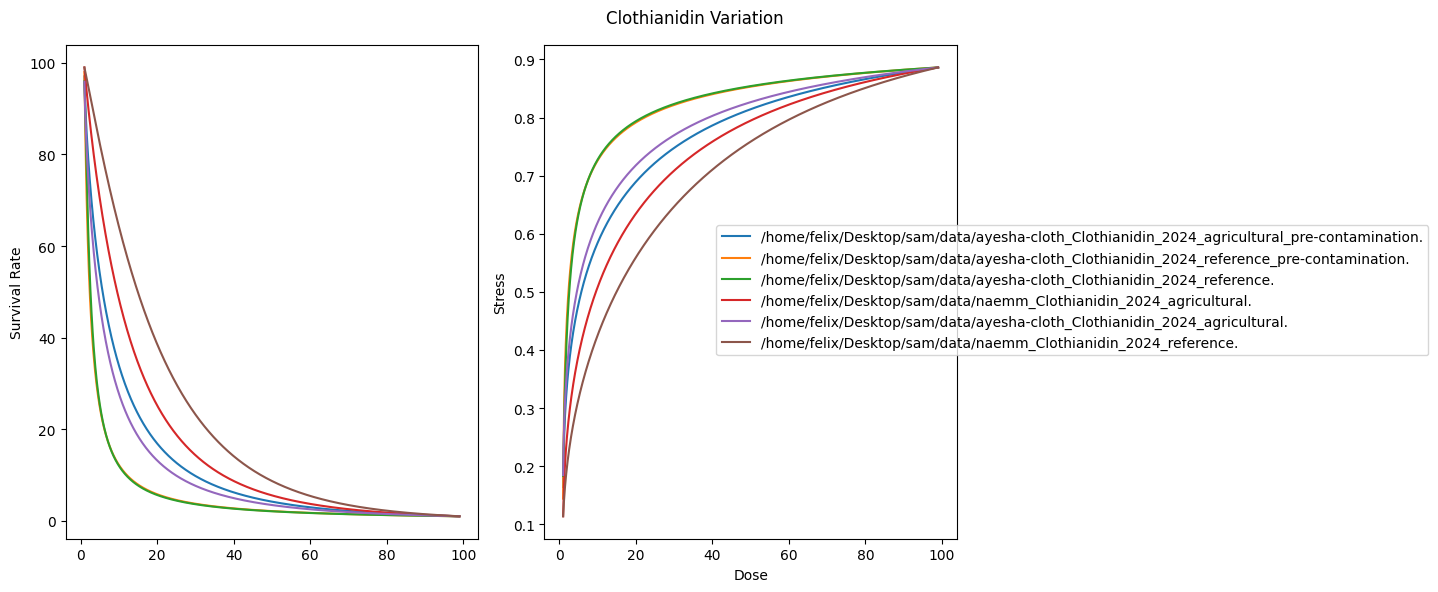

In [22]:
fig = plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
for col, row in df.query("chemical == 'Clothianidin'").iterrows():
    plt.plot(np.linspace(1, 99, 1000), row['normed_curves'], label = row.title)

plt.ylabel('Survival Rate')
plt.subplot(1,2,2)
for col, row in df.query("chemical == 'Clothianidin'").iterrows():
    plt.plot(np.linspace(1, 99, 1000), row.stress, label = row.title)

plt.legend(bbox_to_anchor = (0.4,.65))
plt.xlabel('Dose')
plt.ylabel('Stress')
plt.suptitle("Clothianidin Variation")
plt.tight_layout()
plt.show()

In [23]:

# Create a DataFrame to store all curves for averaging
curves_df = pd.DataFrame()

curves_df['dose'] = np.linspace(1, 99, 1000)

# Compute normalized curves and stress for each model
for index, row in df.iterrows():
    model = row['model']
    normed_curve = compute_normalised_curve(model)
    stress_curve = survival_to_stress(normed_curve / 100)
    curves_df[f"{row['chemical']}_survival_{index}"] = normed_curve
    curves_df[f"{row['chemical']}_stress_{index}"] = stress_curve


def plot_curves(chemicals):
    # Plot average survival and stress curves with bands
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    for chemical in chemicals:
        survival_columns = [col for col in curves_df.columns if f"{chemical}_survival" in col]
        stress_columns = [col for col in curves_df.columns if f"{chemical}_stress" in col]
        
        avg_survival = curves_df[survival_columns].mean(axis=1)
        min_survival = curves_df[survival_columns].min(axis=1)
        max_survival = curves_df[survival_columns].max(axis=1)
        
        avg_stress = curves_df[stress_columns].mean(axis=1)
        min_stress = curves_df[stress_columns].min(axis=1)
        max_stress = curves_df[stress_columns].max(axis=1)
        
        # Plot survival
        axs[0].plot(curves_df['dose'], avg_survival, label=chemical, color=color_map[chemical])
        axs[0].fill_between(curves_df['dose'], min_survival, max_survival, color=color_map[chemical], alpha=0.3)
        
        # Plot stress
        axs[1].plot(curves_df['dose'], avg_stress, label=chemical, color=color_map[chemical])
        axs[1].fill_between(curves_df['dose'], min_stress, max_stress, color=color_map[chemical], alpha=0.3)

    # Set titles and labels
    axs[0].set_title('Average Survival Curves with Bands')
    axs[0].set_xlabel('LC')
    axs[0].set_ylabel('Survival Rate')
    axs[0].set_xscale("log")

    axs[1].set_title('Average Stress Curves with Bands')
    axs[1].set_xlabel('LC')
    axs[1].set_ylabel('Stress')
    axs[1].set_xscale("log")
    axs[1].legend()

    plt.tight_layout()
    plt.show()


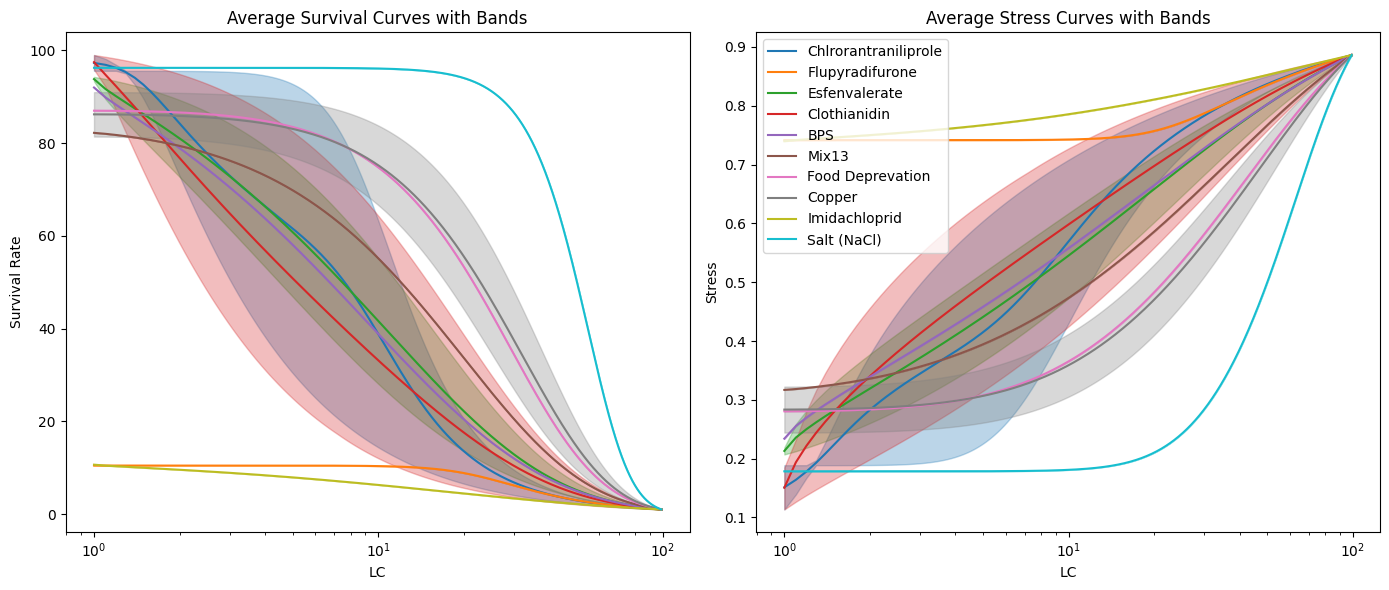

In [24]:
plot_curves(chemicals)

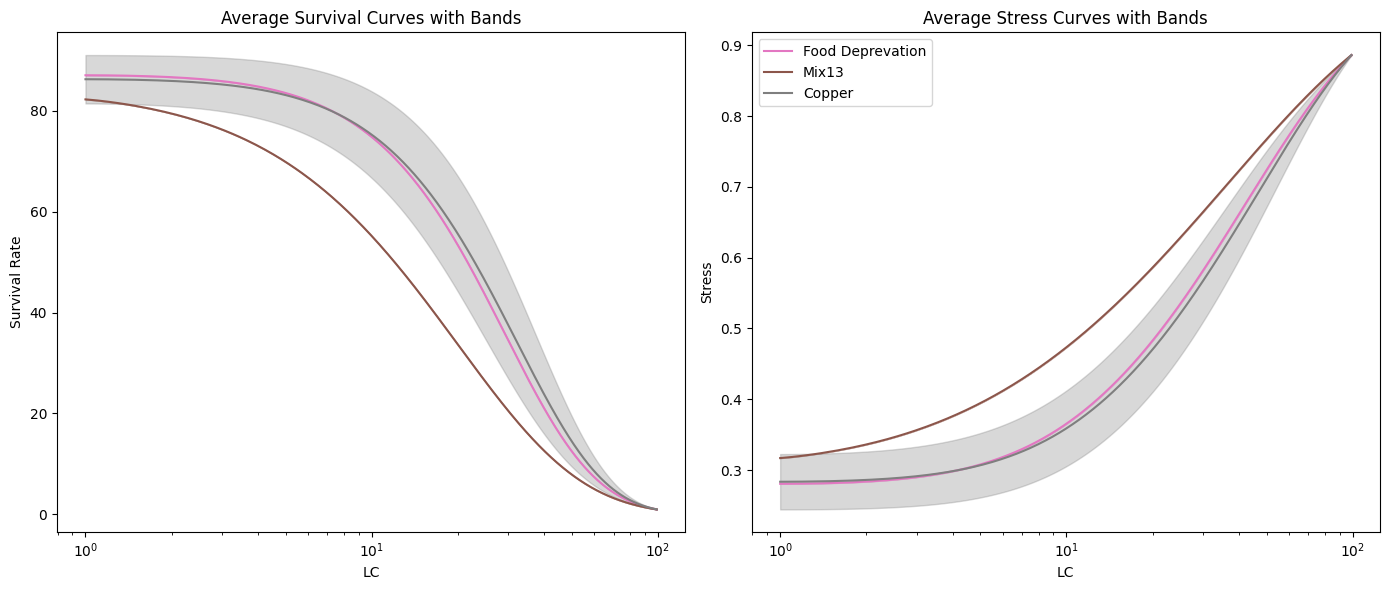

In [25]:
plot_curves(["Food Deprevation", "Mix13", "Copper"])

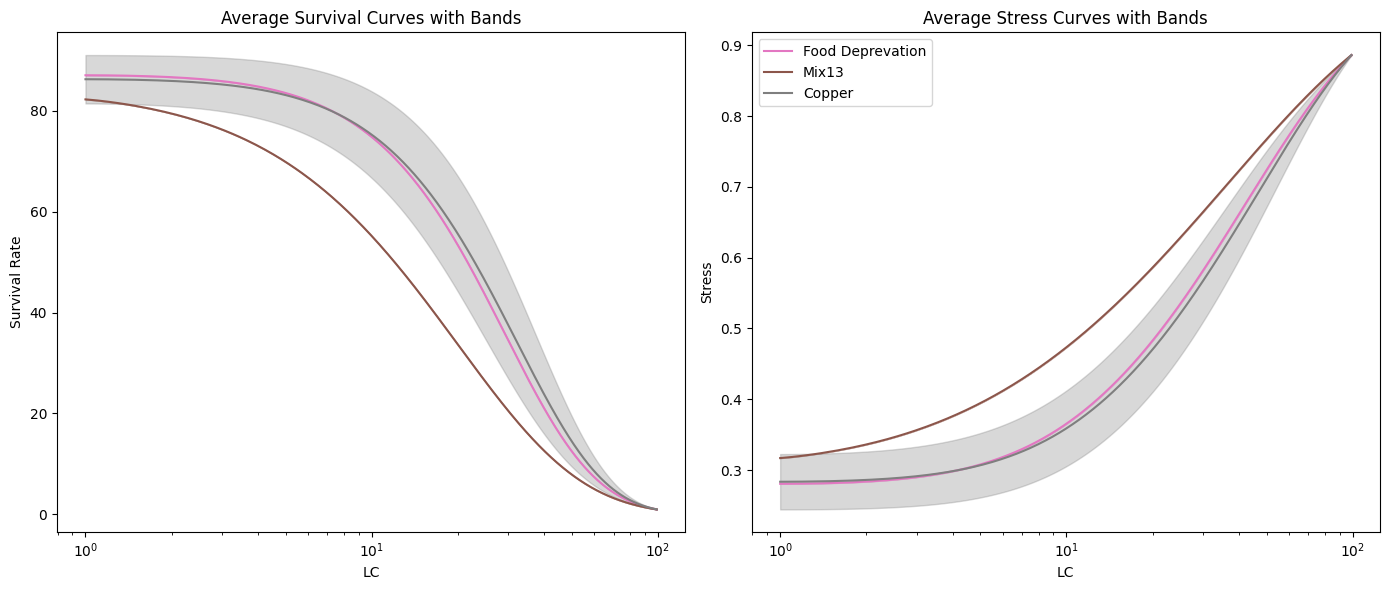

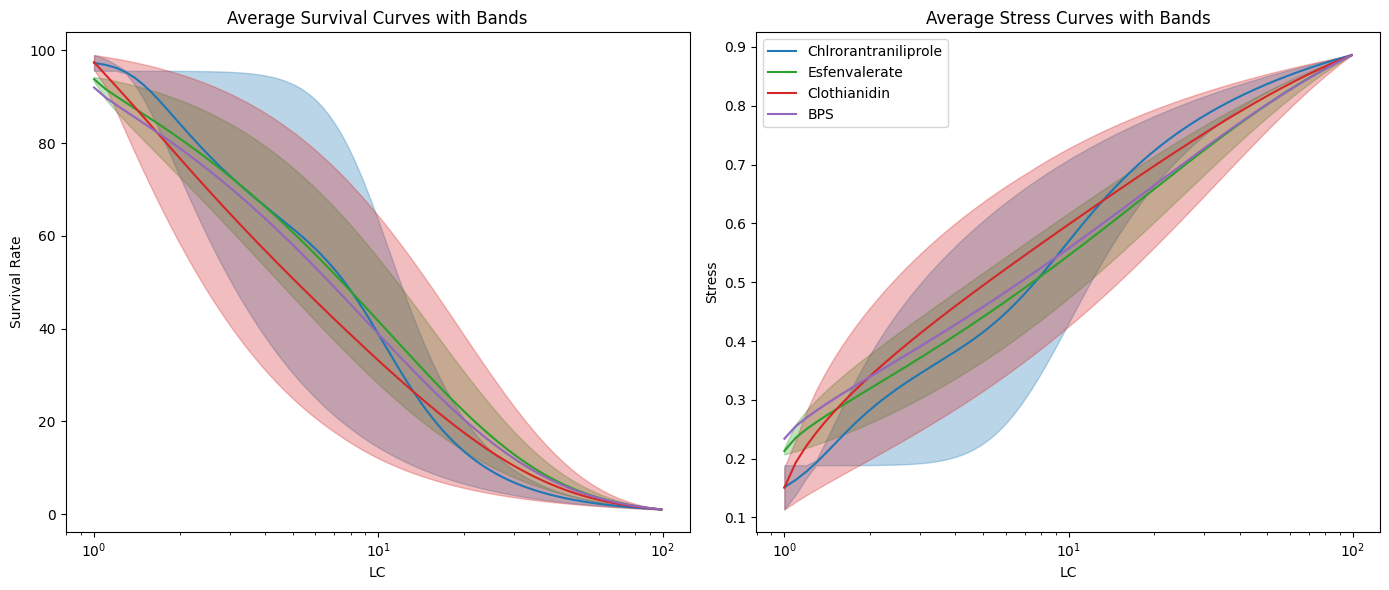

In [26]:
plot_curves(["Food Deprevation", "Mix13", "Copper"])
plot_curves(['Chlrorantraniliprole', 'Esfenvalerate',
       'Clothianidin', 'BPS'])


In [27]:
dfs = []

for path, data in load_files():
    
    meta = data.meta
    res : ModelPredictions = dose_response_fit(data.main_series, FitSettings(param_d_norm=True, survival_max= meta.max_survival, transform=Transforms.none))
    
    title = f"{meta.chemical} - {meta.organism}"
    
    dfs.append({"title" : path[:-4], "chemical":meta.chemical, "organism":meta.organism, "model": res})

df = pd.DataFrame(dfs)
df.head()    

,title,chemical,organism,model
0,/home/felix/Desktop/sam/data/ayesha_chlorantra...,Chlrorantraniliprole,Gammarus pulex,ModelPredictions(concentration_curve=array([1....
1,/home/felix/Desktop/sam/data/huang_Flupyradifu...,Flupyradifurone,Gammarus pulex,ModelPredictions(concentration_curve=array([1....
2,/home/felix/Desktop/sam/data/naeem_Esfenvalera...,Esfenvalerate,Daphnia magna,ModelPredictions(concentration_curve=array([1....
3,/home/felix/Desktop/sam/data/ayesha-cloth_Clot...,Clothianidin,Gammarus pulex,ModelPredictions(concentration_curve=array([1....
4,/home/felix/Desktop/sam/data/ayesha_chlorantra...,Chlrorantraniliprole,Gammarus pulex,ModelPredictions(concentration_curve=array([1....


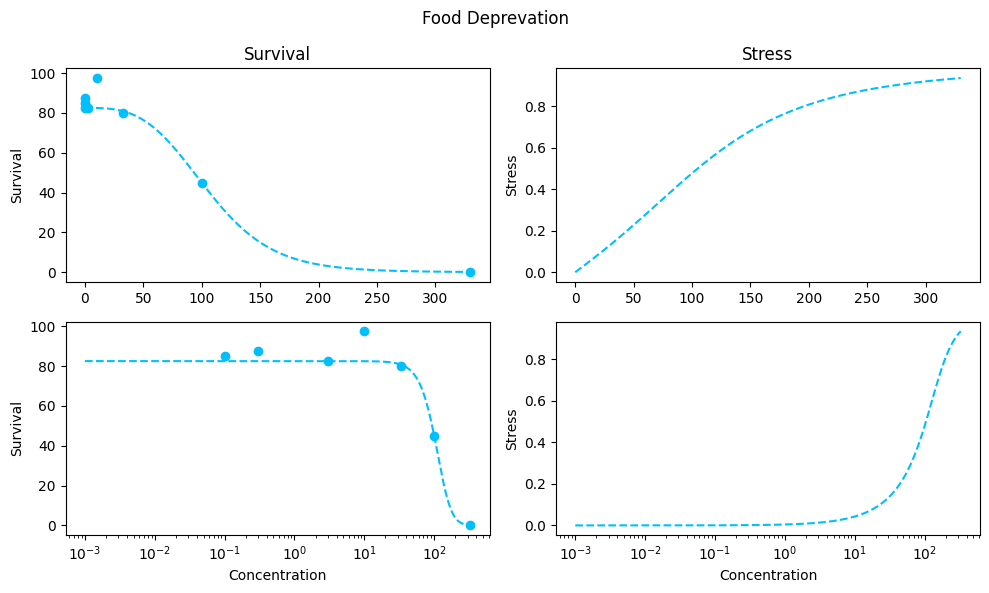

In [28]:
model = df.query("chemical == 'Food Deprevation'").iloc[0].model
fig = plot_fit_prediction(model, "Food Deprevation")

In [29]:
df.chemical.value_counts()

chemical
Clothianidin            6
Chlrorantraniliprole    2
Esfenvalerate           2
Copper                  2
Flupyradifurone         1
BPS                     1
Mix13                   1
Food Deprevation        1
Imidachloprid           1
Salt (NaCl)             1
Name: count, dtype: int64

In [30]:
df.organism.value_counts()

organism
Gammarus pulex    10
Daphnia magna      6
Unknown            1
Amphipod           1
Name: count, dtype: int64

In [31]:
df.value_counts(["chemical", "organism"])

chemical              organism      
Clothianidin          Gammarus pulex    6
Chlrorantraniliprole  Gammarus pulex    2
Esfenvalerate         Daphnia magna     2
BPS                   Daphnia magna     1
Copper                Amphipod          1
                      Daphnia magna     1
Flupyradifurone       Gammarus pulex    1
Food Deprevation      Daphnia magna     1
Imidachloprid         Gammarus pulex    1
Mix13                 Unknown           1
Salt (NaCl)           Daphnia magna     1
Name: count, dtype: int64

In [32]:
def compute_normalised_curve(model : ModelPredictions):
    
    if np.isnan(model.lc1):
        print("nan")
        model.lc1 = 0.0
    
    x = np.linspace(model.lc1, model.lc99, 1000)
    
    return model.model(x) * 100


df["normed_curves"] = df.model.apply(compute_normalised_curve)

df["stress"] = df.normed_curves.apply(lambda x: survival_to_stress(x / 100))

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


/tmp/ipykernel_29856/200940450.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {chemical: color for chemical, color in zip(chemicals, plt.cm.get_cmap('tab10').colors)}


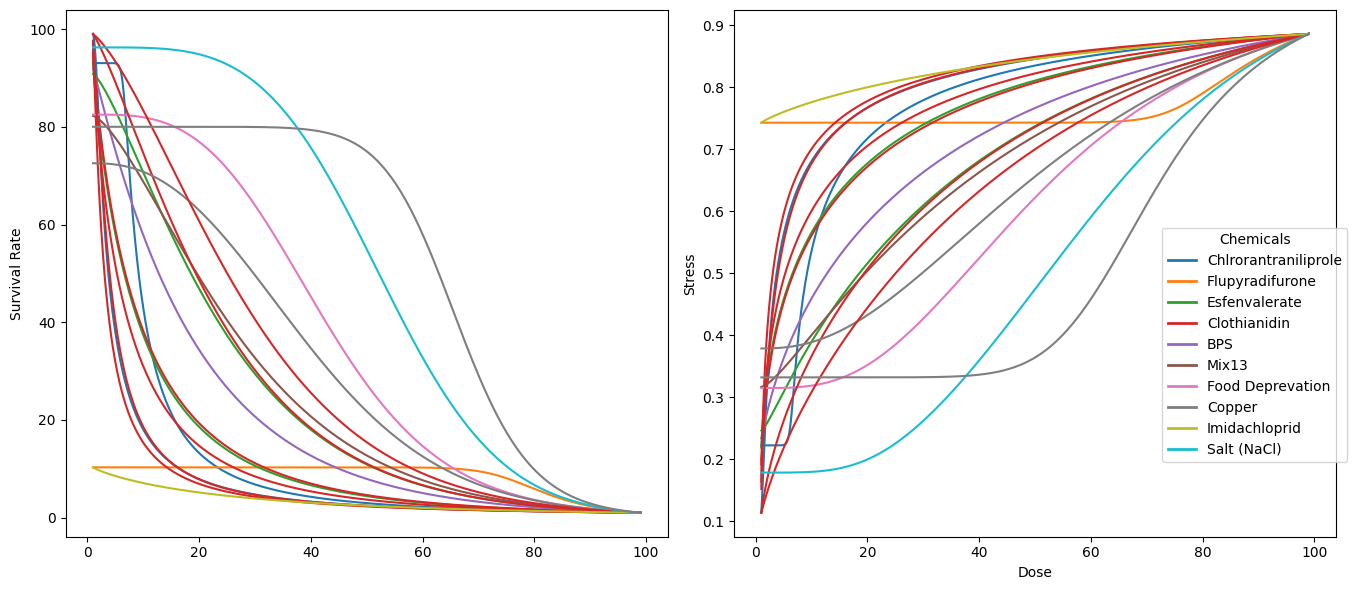

In [33]:
chemicals = df['chemical'].unique()
color_map = {chemical: color for chemical, color in zip(chemicals, plt.cm.get_cmap('tab10').colors)}

# Plot each chemical with the assigned color
fig = plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
for col, row in df.iterrows():
    plt.plot(np.linspace(1, 99, 1000), row['normed_curves'], color=color_map[row['chemical']])

plt.ylabel('Survival Rate')
plt.subplot(1,2,2)
for col, row in df.iterrows():
    plt.plot(np.linspace(1, 99, 1000), row.stress, color=color_map[row['chemical']])


handles = [plt.Line2D([0], [0], color=color_map[chem], lw=2) for chem in chemicals]
labels = [chem for chem in chemicals]
plt.legend(handles, labels, title="Chemicals", bbox_to_anchor = (0.7,0.6))

plt.xlabel('Dose')
plt.ylabel('Stress')
plt.tight_layout()
plt.show()

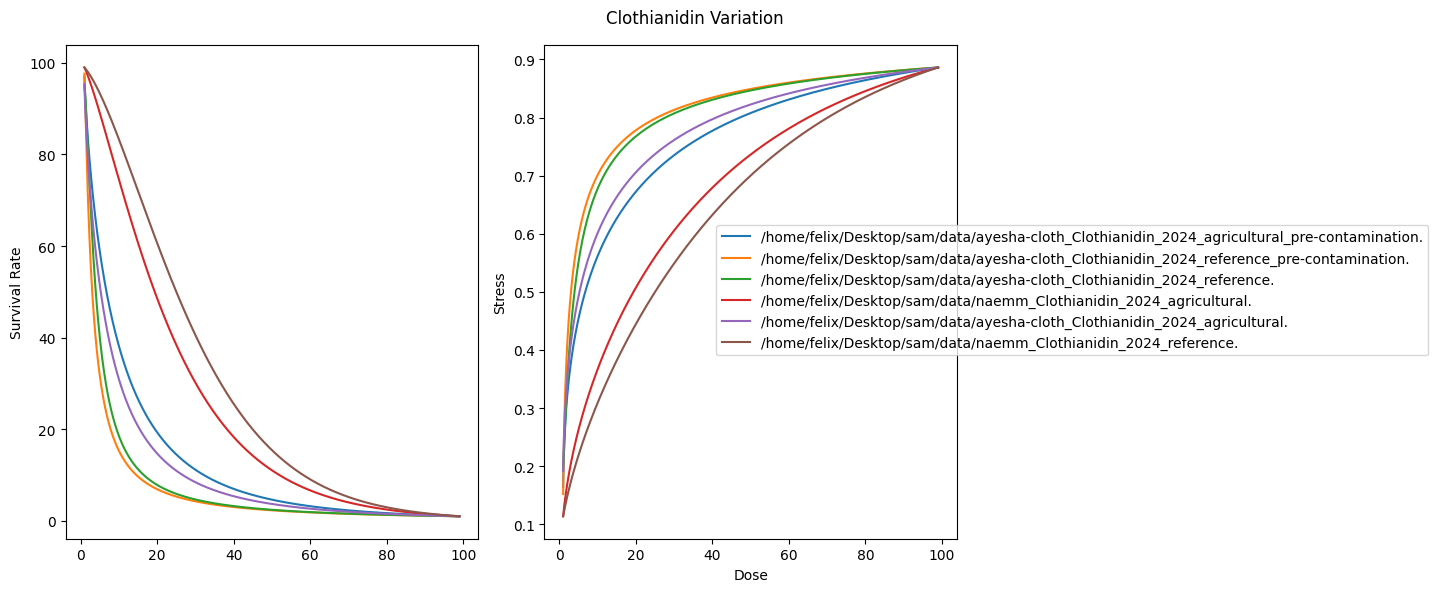

In [34]:
fig = plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
for col, row in df.query("chemical == 'Clothianidin'").iterrows():
    plt.plot(np.linspace(1, 99, 1000), row['normed_curves'], label = row.title)

plt.ylabel('Survival Rate')
plt.subplot(1,2,2)
for col, row in df.query("chemical == 'Clothianidin'").iterrows():
    plt.plot(np.linspace(1, 99, 1000), row.stress, label = row.title)

plt.legend(bbox_to_anchor = (0.4,.65))
plt.xlabel('Dose')
plt.ylabel('Stress')
plt.suptitle("Clothianidin Variation")
plt.tight_layout()
plt.show()

In [35]:

# Create a DataFrame to store all curves for averaging
curves_df = pd.DataFrame()

curves_df['dose'] = np.linspace(1, 99, 1000)

# Compute normalized curves and stress for each model
for index, row in df.iterrows():
    model = row['model']
    normed_curve = compute_normalised_curve(model)
    stress_curve = survival_to_stress(normed_curve / 100)
    curves_df[f"{row['chemical']}_survival_{index}"] = normed_curve
    curves_df[f"{row['chemical']}_stress_{index}"] = stress_curve


def plot_curves(chemicals):
    # Plot average survival and stress curves with bands
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    for chemical in chemicals:
        survival_columns = [col for col in curves_df.columns if f"{chemical}_survival" in col]
        stress_columns = [col for col in curves_df.columns if f"{chemical}_stress" in col]
        
        avg_survival = curves_df[survival_columns].mean(axis=1)
        min_survival = curves_df[survival_columns].min(axis=1)
        max_survival = curves_df[survival_columns].max(axis=1)
        
        avg_stress = curves_df[stress_columns].mean(axis=1)
        min_stress = curves_df[stress_columns].min(axis=1)
        max_stress = curves_df[stress_columns].max(axis=1)
        
        # Plot survival
        axs[0].plot(curves_df['dose'], avg_survival, label=chemical, color=color_map[chemical])
        axs[0].fill_between(curves_df['dose'], min_survival, max_survival, color=color_map[chemical], alpha=0.3)
        
        # Plot stress
        axs[1].plot(curves_df['dose'], avg_stress, label=chemical, color=color_map[chemical])
        axs[1].fill_between(curves_df['dose'], min_stress, max_stress, color=color_map[chemical], alpha=0.3)

    # Set titles and labels
    axs[0].set_title('Average Survival Curves with Bands')
    axs[0].set_xlabel('LC')
    axs[0].set_ylabel('Survival Rate')
    axs[0].set_xscale("log")

    axs[1].set_title('Average Stress Curves with Bands')
    axs[1].set_xlabel('LC')
    axs[1].set_ylabel('Stress')
    axs[1].set_xscale("log")
    axs[1].legend()

    plt.tight_layout()
    plt.show()


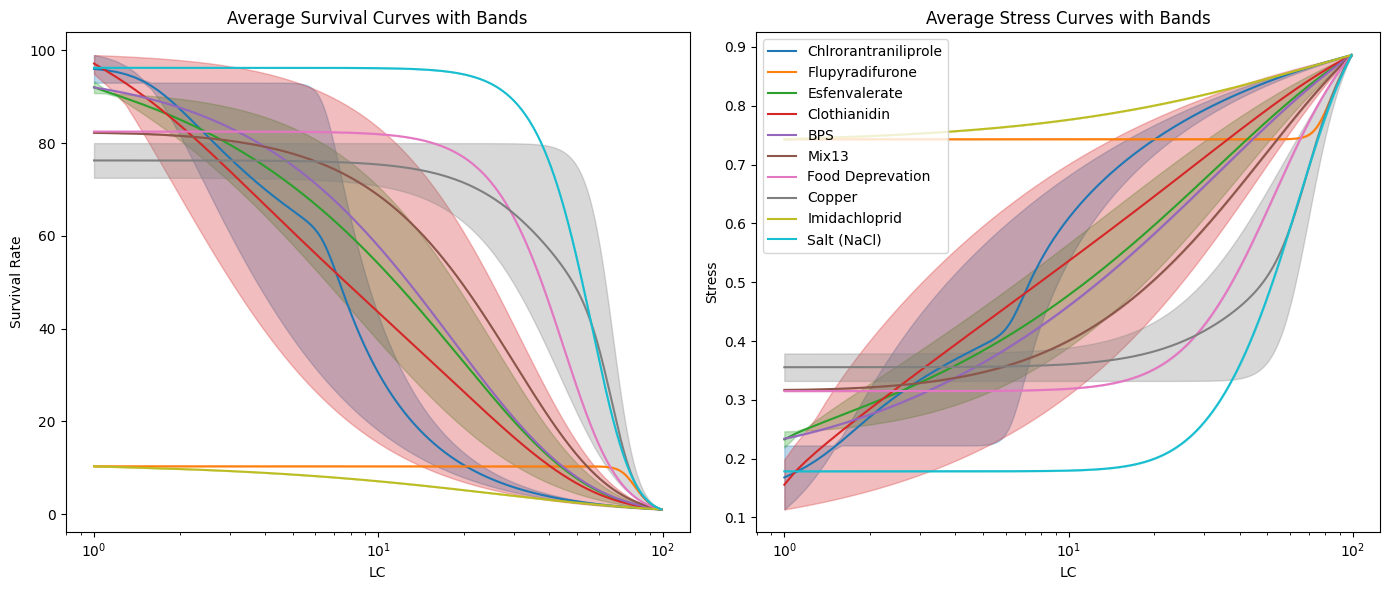

In [36]:
plot_curves(chemicals)

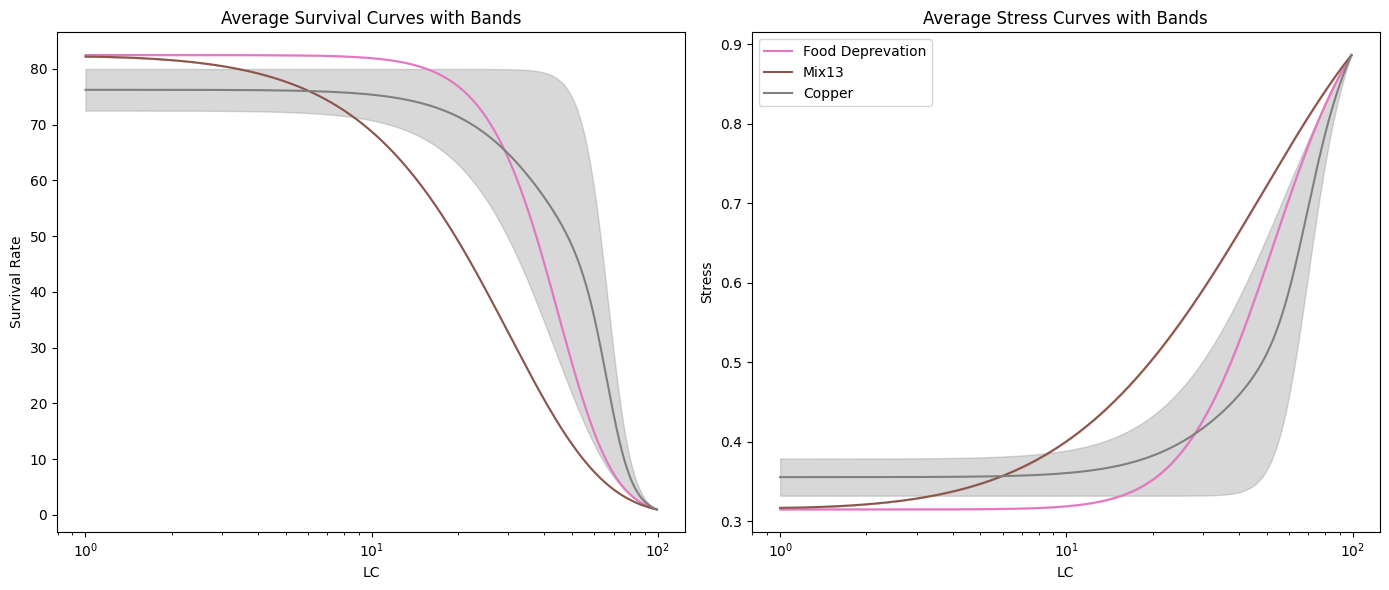

In [37]:
plot_curves(["Food Deprevation", "Mix13", "Copper"])

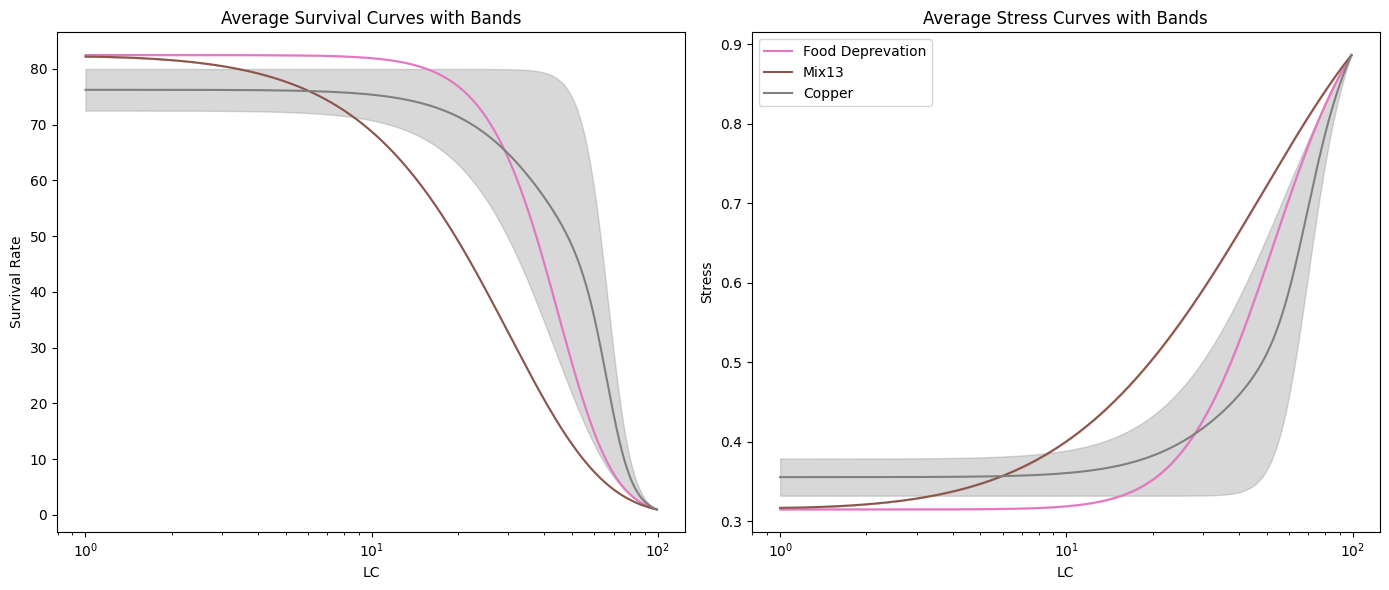

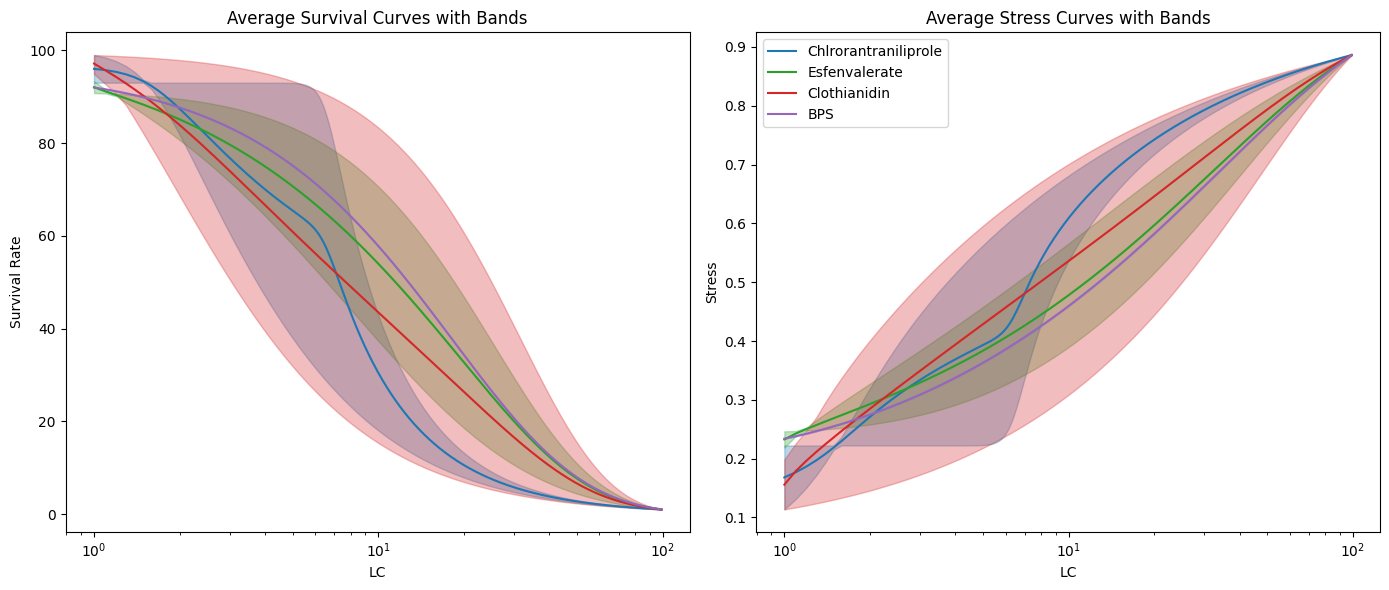

In [38]:
plot_curves(["Food Deprevation", "Mix13", "Copper"])
plot_curves(['Chlrorantraniliprole', 'Esfenvalerate',
       'Clothianidin', 'BPS'])
